## CS 329E Data Analytics Spring 2024 Final Project

George Mathew (ggm596)

Jack Yeung (jay697)

## Project Definition
We are using the fetal health classification dataset from Kaggle (https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification). This dataset provides information regarding fetal health following birth, including several biometric markers for the baby and the mother. 

This dataset has slightly over 2000 observations and will be limited to a randomly sampled 2000 observations of the original dataset using a random seed generator to make results replicable.

This project aims to use these biomarkers to determine the most influential identifiers in predicting post-natal fetal health. Since the provided data targets are formatted according to 3 classes (as described later), this project will use multiclass classification methods to answer this question.

Given the initial feature set, we expect severe_decelerations, fetal_movement, and abnormal_short_term_viability to be the three most significant predictors of fetal health. Severe decelerations would indicate that there is not enough bloodflow to the child, low fetal_movement could indicate an unresponsive case, and abnormal short term viability could indicate insufficient cardiovascular system control. All of these could be fatal and we expect them to be strongly negatively correlated with fetal health.

Evaluation of our classification models will be performed using the standard metrics learned in class in combination with other accuracy metrics used commonly in the industry. For example, ROC curve analysis will be performed to compare model performance and evaluate the accuracy of the chosen model's classifications. The final results will be analyzed using our team's domain knowledge to ensure the results align with what we expected. If results differ, they will be logically compared to our expectations to determine the validity of our results and if changes need to be made.

## Import Dependencies and Data

In [2]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import GradientBoostingClassifier

/Users/georgemathew/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/z6/d0zj0b9s1lv9vyh5km30751h0000gn/T/ipykernel_56352/3687150139.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df = pd.read_csv('fetal_health.csv')

## Summarize Data:

This dataset contains information regarding fetal health and several metrics used to evaluate fetal health. Fetal health is classified into 3 groups: 1 (Normal), 2 (Suspect), 3 (Pathological). The relevant features include several infant cardiac measures and some information regarding the mother's health.

The goal of this project is to identify the most important features in predicting fetal health.

In [22]:
print(f'Dataset shape before limiting observation size to 2000: {df.shape}')
df = df[:2000]
print(f'Dataset shape after limiting observation size to 2000: {df.shape}')

Dataset shape before limiting observation size to 2000: (2126, 22)
Dataset shape after limiting observation size to 2000: (2000, 22)


In [25]:
df.columns

Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')

In [5]:
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [6]:
df.tail()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
2121,140.0,0.000,0.000,0.007,0.0,0.0,0.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.0,0.0,0.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.0,0.0,0.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.0,0.0,0.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0
2125,142.0,0.002,0.002,0.008,0.0,0.0,0.0,74.0,0.4,36.0,...,117.0,159.0,2.0,1.0,145.0,143.0,145.0,1.0,0.0,1.0


In [7]:
df.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


## Data Cleaning and Preprocessing:
Handle Missing Values: Check for missing or zero values that may need to be imputed or handled appropriately.

Data Transformation: Normalize or standardize the continuous features such as Glucose, BloodPressure, BMI, etc., as they seem to be on different scales.  

Categorical Encoding: If there are any categorical variables not included in the sample provided, they should be encoded properly using techniques like one-hot encoding.

In [8]:
null_counts = df.isnull().sum()
print(f'Number of null values in each column:\n{null_counts}')

Number of null values in each column:
baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
hi

In [9]:
# Drop hist features since they seem useless
columns_to_drop = [column for column in df.columns if 'histogram' in column.lower()]
cleaned_df = df.drop(columns=columns_to_drop)
cleaned_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,1.0


## Exploratory Data Analysis
Statistical Summary: Generate descriptive statistics to understand the distribution of the data.


Visualization: Create visual plots (like histograms, box plots, scatter plots) to see the distribution of features and the relationship between features and the outcome.


Correlation Analysis: Check the correlation between features to identify multicollinearity.

In [10]:
# Statistical summary
statistical_summary = cleaned_df.describe()
statistical_summary

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000,3.000000


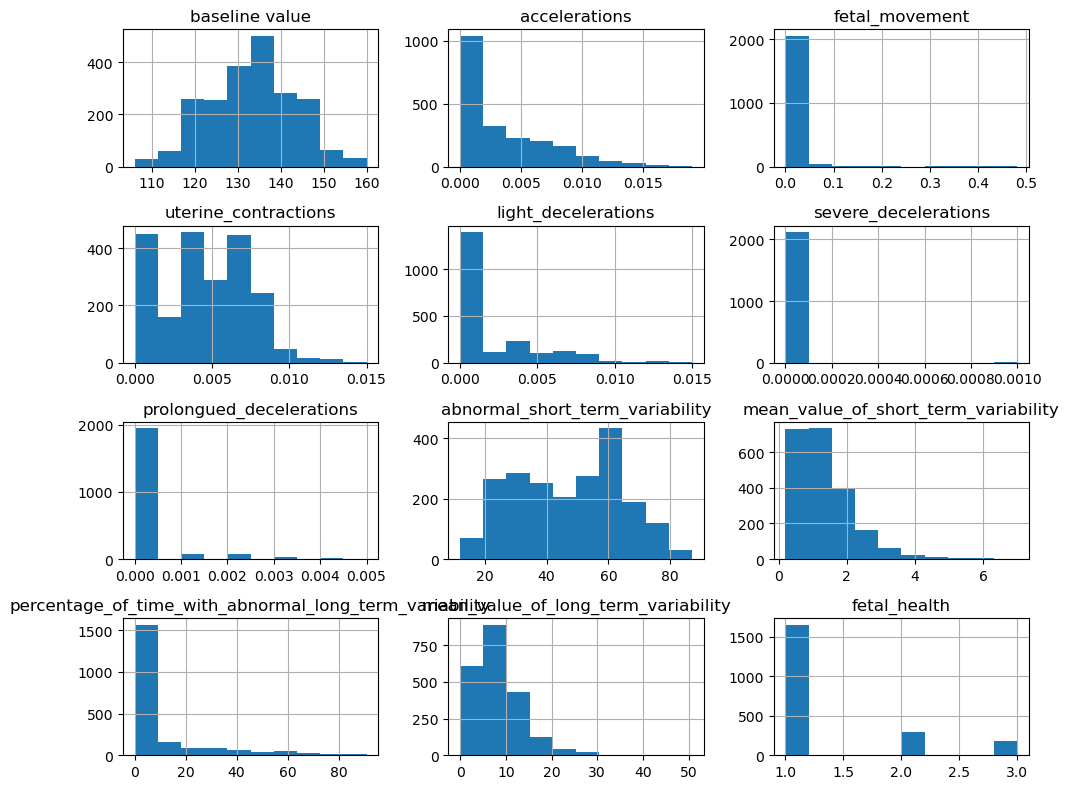

In [11]:
# Histograms for all features
cleaned_df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

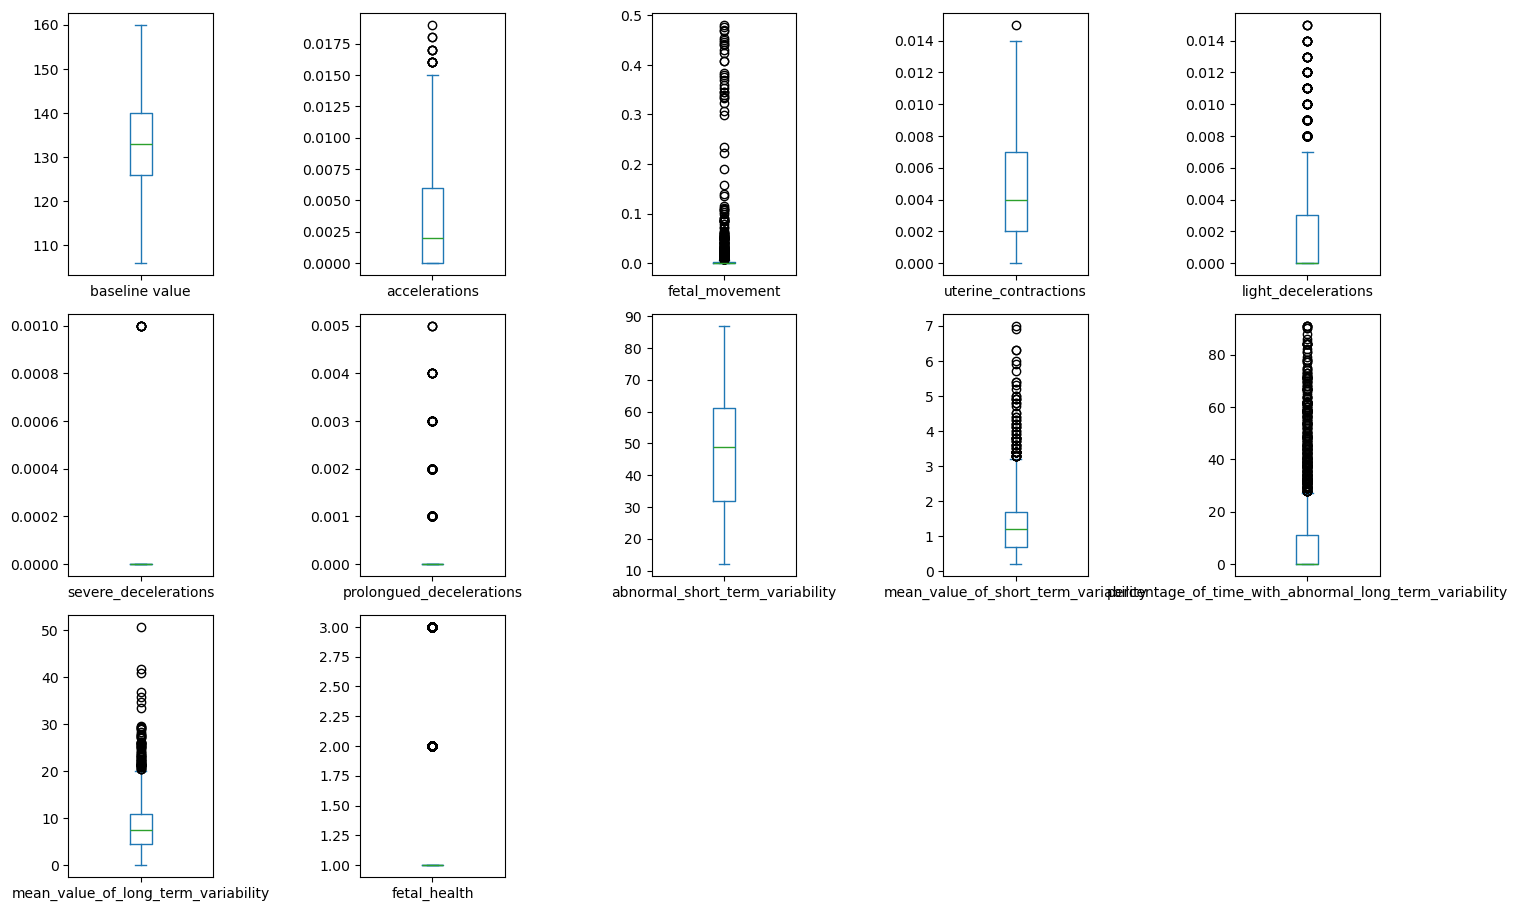

In [12]:
# Box plots for all features
cleaned_df.plot(kind='box', subplots=True, layout=(5,5), figsize=(15, 15))
plt.tight_layout()
plt.show()

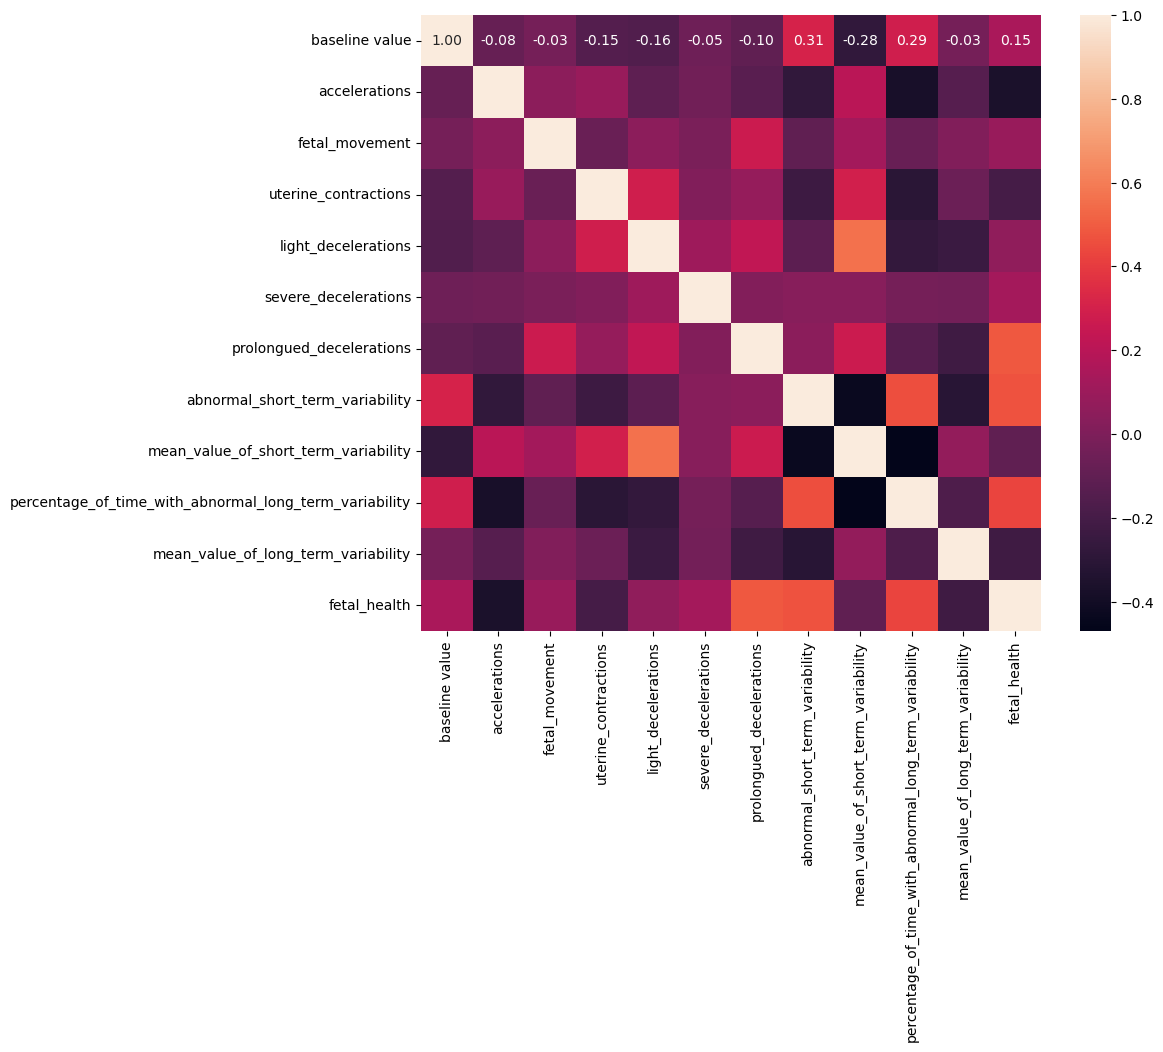

In [13]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cleaned_df.corr(), annot=True, fmt=".2f")
plt.show()

## Problem Definition

This is a multiclass classification problem because the outcome has three possible labels; the 'fetal_health' oucome can be tagged as 1 (Normal), 2 (Suspect) or 3 (Pathological).

## Model Deployment

Model Selection: Random Forest


We plan to use Random Forest for this task as it builds upon the concept of decision trees. Random Forest, being an ensemble of decision trees, typically performs better than single decision trees by reducing overfitting and variance. Each tree in the forest votes, and the most popular class is chosen as the final outcome, which can yield more reliable predictions.



Training: Train the model(s) on the training dataset.  
Evaluation Metrics: Evaluate models using metrics such as accuracy, precision, recall, F1-score, ROC-AUC curve.

Validation: Evaluate the final model on a separate validation set that was not used during the model training phase to check for overfitting.  
Learning Curves: Plot learning curves to diagnose if the model is learning well or if it's overfitting or underfitting.

Prediction: Use the final model to make predictions on new data.  
Interpret Results: Use tools like SHAP or LIME for model interpretation to understand how different features affect the outcome.

In [14]:
# Set up the training and test sets
X = cleaned_df.drop('fetal_health', axis=1)  # Features
y = cleaned_df['fetal_health']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])

In [15]:
# Train RF classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train);

In [16]:
# Test RF classifier
y_pred_rf = rf_classifier.predict(X_test)
y_pred_proba_rf = rf_classifier.predict_proba(X_test)

# Evaluate RF classifier
accuracy_rf = accuracy_score(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf, target_names=['Class 1', 'Class 2', 'Class 3'])

print(f'Accuracy: {accuracy_rf}')
print(f'Classification report: \n{class_report}')

Accuracy: 0.9294670846394985
Classification report: 
              precision    recall  f1-score   support

     Class 1       0.94      0.98      0.96       497
     Class 2       0.84      0.66      0.74        88
     Class 3       0.94      0.89      0.91        53

    accuracy                           0.93       638
   macro avg       0.91      0.84      0.87       638
weighted avg       0.93      0.93      0.93       638



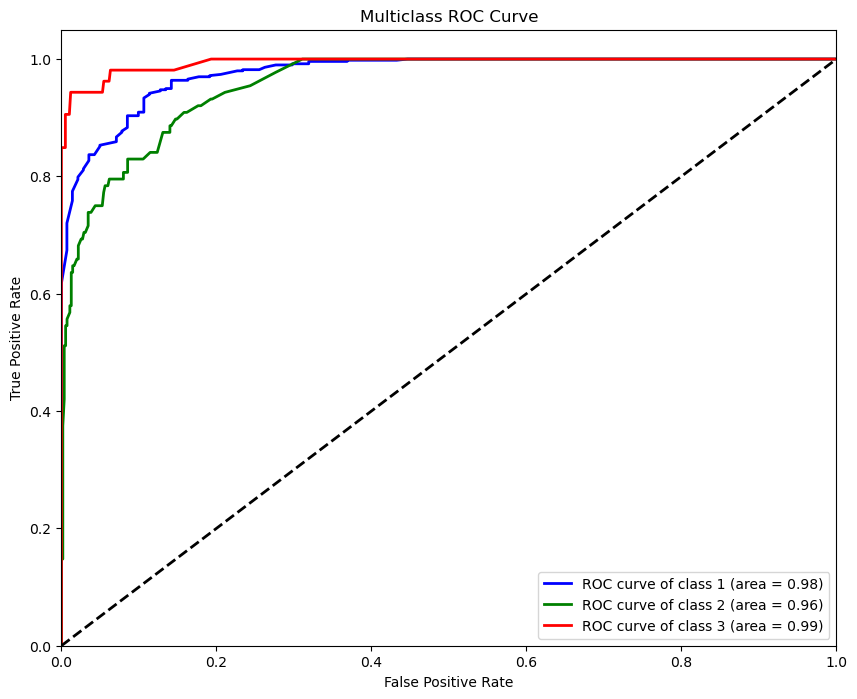

In [17]:
# ROC CURVE
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = cleaned_df['fetal_health'].nunique()

# Calculate false + true positive rates + area under the curve for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

Gradient Boosting Machines (GBM):  
GBM sequentially builds trees where each tree tries to correct the mistakes of the previous one. This can lead to highly accurate models, although they might be less interpretable than single trees.

In [18]:
# Train GBM classifier
gbm_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm_classifier.fit(X_train, y_train);

In [19]:
# Test GBM classifier
y_pred_gbm = gbm_classifier.predict(X_test)

# Evaluate GBM classifier
accuracy = accuracy_score(y_test, y_pred_gbm)
GBM_class_report = classification_report(y_test, y_pred_gbm)

print(f'Accuracy: {accuracy}')
print(f'Classification Report: \n {GBM_class_report}')

Accuracy: 0.9278996865203761
Classification Report: 
               precision    recall  f1-score   support

         1.0       0.94      0.97      0.96       497
         2.0       0.86      0.67      0.75        88
         3.0       0.88      0.92      0.90        53

    accuracy                           0.93       638
   macro avg       0.89      0.86      0.87       638
weighted avg       0.93      0.93      0.92       638



What features contributed most to the prediction?

In [20]:
# Get feature importances from the RF model
rf_feature_importances = rf_classifier.feature_importances_
feature_names = X.columns.tolist()
rf_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_feature_importances}).sort_values(by='Importance', ascending=False)

# Show the top features contributing to the RF model
rf_importances_df


,Feature,Importance
7,abnormal_short_term_variability,0.182998
8,mean_value_of_short_term_variability,0.172093
9,percentage_of_time_with_abnormal_long_term_var...,0.155595
6,prolongued_decelerations,0.113031
10,mean_value_of_long_term_variability,0.105147
0,baseline value,0.075038
3,uterine_contractions,0.067735
1,accelerations,0.061814
2,fetal_movement,0.037275
4,light_decelerations,0.023876


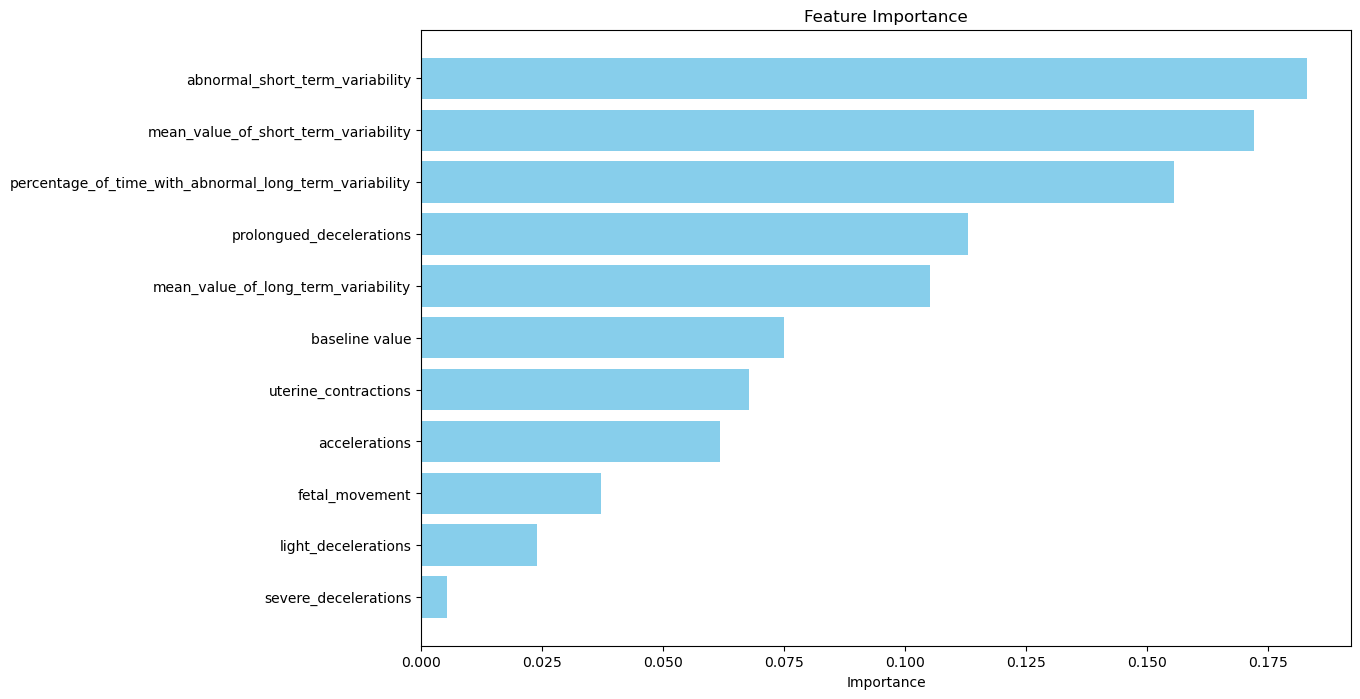

In [21]:
# Feature Importance Curve
plt.figure(figsize=(12, 8))
plt.barh(rf_importances_df['Feature'], rf_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()